In [1]:
import numpy as np
import pandas as pd
import os.path
import librosa
import IPython.display as ipd
from shutil import copyfile
import glob
import matplotlib.style as ms
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import random
import time

import IPython.display
import librosa.display
import joblib
from joblib import Parallel, delayed
from PIL import Image
import multiprocessing as mp

In [25]:
sr = 22050

In [ ]:
import pandas as pd
import math

labels_df = pd.read_csv('/root/autodl-tmp/SER/speech-emotion-recognition-iemocap-master/SER_new/preprocess_info/df_iemocap.csv')
iemocap_dir = '/root/autodl-tmp/SER/speech-emotion-recognition-iemocap-master/SER_new/IEMOCAP_full_release/'
save_dir = '/root/autodl-tmp/SER/speech-emotion-recognition-iemocap-master/SER_new/preprocess_info/'
audio_vectors_path= save_dir + 'audio_vectors_'

In [4]:
labels_df.emotion.value_counts()

xxx    2507
fru    1849
neu    1708
ang    1103
sad    1084
exc    1041
hap     595
sur     107
fea      40
oth       3
dis       2
Name: emotion, dtype: int64

In [5]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'exc': 2,
                'sad': 3,
                'fru': 4,
                'fea': 5,
                'sur': 6,
                'neu': 7,
                'xxx': 8,
                'oth': 8,
                'dis': 8}

In [57]:
emotion_full_dict = {'neu': 'neutral', 'ang': 'anger', 'hap': 'happiness', 'exc': 'excited', 'sad': 'sadness',
                     'fru':'frustrated', 'fea': 'fear', 'sur': 'surprised', 'xxx': 'others', 'oth': 'others', 'dis': 'others'}

In [4]:
labels_df.shape

(10039, 7)

In [5]:
labels_df.head()

,start_time,end_time,wav_file,emotion,val,act,dom
0,3.9500,10.5900,Ses01F_impro07_F000,exc,5.0,5.0,4.5
1,11.3600,16.5575,Ses01F_impro07_F001,xxx,4.0,4.5,3.5
2,19.6100,31.6500,Ses01F_impro07_F002,exc,4.0,4.0,3.0
3,32.5200,34.9000,Ses01F_impro07_F003,exc,4.5,4.5,4.5
4,37.1625,42.4900,Ses01F_impro07_F004,exc,3.0,3.5,3.0


In [36]:
labels_df[labels_df["wav_file"].str.contains("Ses01")].shape

(1819, 7)

In [7]:
labels_df[labels_df["wav_file"].str.contains("Ses02")].shape

(1811, 7)

In [8]:
labels_df[labels_df["wav_file"].str.contains("Ses03")].shape

(2136, 7)

In [9]:
labels_df[labels_df["wav_file"].str.contains("Ses04")].shape

(2103, 7)

In [10]:
labels_df[labels_df["wav_file"].str.contains("Ses05")].shape

(2170, 7)

In [7]:
labels_df_subset = labels_df[labels_df["emotion"].isin(["neu", 'ang', 'hap', 'sad'])]

In [8]:
labels_df_subset.emotion.value_counts()

neu    1708
ang    1103
sad    1084
hap     595
Name: emotion, dtype: int64

In [37]:
labels_df_subset = labels_df_subset[["wav_file", "emotion"]]

In [40]:
labels_df_subset = labels_df_subset.rename(columns={"wav_file": "filename"})

In [41]:
labels_df_subset.head()

,filename,emotion
29,Ses01F_impro07_M012,neu
30,Ses01F_impro07_M013,neu
35,Ses01F_impro07_M018,neu
36,Ses01F_impro07_M019,hap
37,Ses01F_impro03_F000,hap


In [9]:
pickle_to_df = pd.DataFrame(columns=["filename", "audio_vector"])

In [ ]:
import gc  # 引入垃圾回收库以便释放内存

for sess in range(1, 6):
    # 使用 with 语句打开 pkl 文件，保证文件及时关闭
    with open('{}{}.pkl'.format(audio_vectors_path, sess), 'rb') as f:
        audio_vectors = pickle.load(f)

    # 遍历该会话对应的标签数据
    for index, row in tqdm(labels_df[labels_df['wav_file'].str.contains('Ses0{}'.format(sess))].iterrows()):
        
        # 获取音频文件名
        wav_file_name = row['wav_file']
        
        # 从 audio_vectors 中提取音频向量
        if wav_file_name in audio_vectors:
            y = audio_vectors[wav_file_name]
            list_y = list(y)  # 将 NumPy 数组转换为列表
            
            # 将文件名和音频向量追加到 DataFrame 中
            pickle_to_df = pickle_to_df.append({'filename': wav_file_name, 'audio_vector': list_y}, ignore_index=True)

    # 打印处理进度
    print(f"Session {sess} processing finished.")
    
    # 手动删除 audio_vectors 以释放内存
    del audio_vectors
    gc.collect()  # 强制进行垃圾回收



1819it [00:17, 102.52it/s]
1811it [00:15, 120.48it/s]
2136it [00:18, 113.19it/s]
2103it [00:18, 115.87it/s]
2170it [00:31, 68.59it/s] 


In [ ]:

with open('/root/autodl-tmp/SER/speech-emotion-recognition-iemocap-master/SER_new/preprocess_info/pickle_to_audiodf.csv', 'w') as f:
    # 写入列名
    pickle_to_df.head(0).to_csv(f, index=False)
    
    # 使用 tqdm 逐行写入数据，并显示进度条
    for i in tqdm(range(len(pickle_to_df))):
        pickle_to_df.iloc[[i]].to_csv(f, header=False, index=False)

In [12]:
pickle_to_df.shape

(10039, 2)

In [13]:
pickle_to_df.head()

,filename,audio_vector
0,Ses01F_impro07_F000,"[-0.014475782, -0.019586077, -0.021079177, -0...."
1,Ses01F_impro07_F001,"[0.0028844632, -0.00027148638, -0.0038992136, ..."
2,Ses01F_impro07_F002,"[0.013327659, 0.009810394, 0.003759945, 0.0004..."
3,Ses01F_impro07_F003,"[0.0014638001, 0.003141048, 0.0072772643, 0.01..."
4,Ses01F_impro07_F004,"[-0.011886216, -0.012354498, -0.013181173, -0...."


In [42]:
pickle_to_subset = labels_df_subset.merge(pickle_to_df, on="filename")

In [43]:
print(pickle_to_subset.shape)
print(pickle_to_df.shape)
print(labels_df_subset.shape)

(4490, 3)
(10039, 2)
(4490, 2)


In [45]:
pickle_to_subset.head()

,filename,emotion,audio_vector
0,Ses01F_impro07_M012,neu,"[-0.001751249, -0.0022995116, -0.0022942421, -..."
1,Ses01F_impro07_M013,neu,"[0.0003422114, 0.0027063466, 0.0076859626, 0.0..."
2,Ses01F_impro07_M018,neu,"[0.032214236, 0.035951234, 0.03672457, 0.03514..."
3,Ses01F_impro07_M019,hap,"[-0.08024377, -0.078011915, -0.084221944, -0.1..."
4,Ses01F_impro03_F000,hap,"[-0.002304704, -0.0011479069, -0.001996223, -0..."


In [ ]:
pathAudio = iemocap_dir
pathImage = '/root/autodl-tmp/SER/speech-emotion-recognition-iemocap-master/SER_new/IEMOCAP_Image/'

In [ ]:
sr = 22050
start = time.time()
# 定义函数生成并保存梅尔频谱图
def save_spectrogram(y, image_fname, label):
    try:
        start1 = time.time()
        print(f"Processing file {image_fname}, length of audio vector: {len(y)}")
        
        # 检查标签是否在情感字典中
        if label not in emotion_full_dict:
            print(f"Label {label} not found in emotion_full_dict")
            return
        
        # 生成梅尔频谱图
        S = librosa.feature.melspectrogram(y=np.asarray(y), sr=sr, n_mels=128)
        log_S = librosa.power_to_db(S, ref=np.max)
        
        # 显示频谱图
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
        plt.axis('off')  # 关闭坐标轴
        plt.draw()  # 绘制图像

        # 生成保存路径
        save_path = os.path.join(pathImage, emotion_full_dict[label], f"{image_fname}.jpg")
        
        # 检查保存目录是否存在，如果不存在则创建
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        
        # 保存频谱图
        plt.savefig(save_path, dpi=50, bbox_inches='tight', pad_inches=0)
        plt.close()  # 关闭图形，释放内存
        end1 = time.time()
        print(f"Spectrogram saved for {image_fname}, time taken: {end1 - start1} seconds")
        
    except Exception as e:
        print(f"Failed to save spectrogram for file {image_fname}, error: {e}")


# 加载音频向量并合并为 DataFrame
pickle_to_df = pd.DataFrame(columns=["filename", "audio_vector"])
for sess in range(1, 6):
    audio_vectors = pickle.load(open(f'{audio_vectors_path}{sess}.pkl', 'rb'))
    for index, row in tqdm(labels_df[labels_df['wav_file'].str.contains(f'Ses0{sess}')].iterrows()):
        wav_file_name = row['wav_file']
        y = audio_vectors.get(wav_file_name, None)
        if y is not None:
            list_y = list(y)
            pickle_to_df = pickle_to_df.append({'filename': wav_file_name, 'audio_vector': list_y}, ignore_index=True)

# 选择特定情感的子集
labels_df_subset = labels_df[labels_df["emotion"].isin(["neu", 'ang', 'hap', 'sad'])]
labels_df_subset = labels_df_subset[["wav_file", "emotion"]]
labels_df_subset = labels_df_subset.rename(columns={"wav_file": "filename"})

# 合并情感标签和音频向量
pickle_to_subset = labels_df_subset.merge(pickle_to_df, on="filename")

# 并行处理生成频谱图
pool = mp.Pool(mp.cpu_count())
pool_starmap = pool.starmap_async(save_spectrogram,
                                  [(getattr(row, "audio_vector"), getattr(row, "filename"), getattr(row, "emotion")) for row in pickle_to_subset.itertuples(index=True, name='Pandas')])

# 等待所有进程完成
pool_starmap.wait()
pool.close()

end = time.time()
print(f"Total time taken: {end - start} seconds")



inside function
0.09028887748718262
inside function
0.06975269317626953
inside function
0.12736749649047852
inside function
0.21600031852722168
inside function
0.18138718605041504
inside function
0.34188389778137207
inside function
0.2857949733734131
inside function
0.3568308353424072
inside function
0.30513739585876465
inside function
0.3956298828125
inside function
0.5662639141082764
inside function
0.3938620090484619
inside function
0.5605061054229736
inside function
0.48540449142456055
inside function
0.38217854499816895
inside function
0.5092554092407227
inside function
0.7459118366241455
inside function
0.7003982067108154
inside function
0.4636707305908203
inside function
0.6400892734527588
inside function
0.745598316192627
inside function
0.632249116897583
inside function
0.6281948089599609
inside function
0.6689863204956055
inside function
0.5606374740600586
inside function
0.5693116188049316
inside function
0.7742009162902832
inside function
0.5943655967712402
inside function


inside function
39.50594162940979
1.628760814666748
inside function
6.548114776611328
inside function
inside function
18.374881267547607
2.9312894344329834
inside function
inside function
5.534847736358643
inside function
2.9499473571777344
inside function
4.046565532684326
inside function
6.822187185287476
inside function
4.328205347061157
inside function
6.184771299362183
inside function
11.481168985366821
inside function
2.3728506565093994
inside function
4.0148491859436035
inside function
0.6833715438842773
inside function
11.389519691467285
inside function
0.4742295742034912
inside function
3.8094420433044434
inside function
12.505537986755371
inside function
10.2567458152771
1.8531417846679688
inside function
inside function
inside function
38.59288811683655
10.159144878387451
inside function
inside function
6.853347063064575
inside function
10.531318664550781
inside function
3.0273935794830322
inside function
14.256407499313354
inside function
23.43435835838318
inside function
1

42.71110439300537
inside function
inside function
39.66956377029419
inside function
6.925254821777344
inside function
46.243064403533936
inside function
inside function
inside function
13.851771354675293
inside function
61.86370253562927
12.04786491394043
inside function
inside function
25.32192087173462
inside function
inside function
1.0274178981781006
inside function
2.4785854816436768
inside function
inside function
60.770015001297
146.56391525268555
inside function
49.461116552352905
inside function
inside function
17.87360906600952
13.354299545288086
inside function
inside function
38.92238736152649
inside function
21.08619475364685
26.54017186164856
65.25513768196106
inside function
inside function
inside function
inside function
inside function
inside function
49.88569688796997
42.69594955444336
50.70658826828003
inside function
23.920666694641113
25.13932466506958
inside function
88.42679858207703
7.4497528076171875
inside function
inside function
27.17408514022827
inside func

36.88714265823364
inside function
55.73669171333313
inside function
77.21462321281433
inside function
inside function
inside function
76.67197227478027
inside function
149.09368801116943
inside function
21.50413489341736
inside function
100.31408333778381
inside function
78.26940131187439
inside function
14.199136734008789
inside function
53.33261728286743
inside function
47.6913001537323
inside function
99.44137239456177
inside function
87.76247072219849
94.72210097312927
92.30312061309814
inside function
75.89096713066101
inside function
inside function
122.22146344184875
43.858617305755615
inside function
inside function
21.381075620651245
inside function
36.284199476242065
inside function
119.70206356048584
inside function
26.293617486953735
inside function
33.72211790084839
inside function
30.380779504776
inside function
87.66276001930237
inside function
33.9043927192688
inside function
inside function
72.575612783432
inside function
inside function
inside function
59.398251056671

91.36227655410767
inside function
96.57772064208984
inside function
inside function
28.458409786224365
inside function
28.008452653884888
inside function
11.08191728591919
inside function
66.13855075836182
inside function
110.70416808128357
71.55060482025146
inside function
58.619502544403076
inside function
72.05290293693542
43.540926456451416
inside function
17.05094337463379
inside function
78.97943925857544
inside function
inside function
inside function
64.06371140480042
85.64326524734497
inside function
174.51819252967834
inside function
inside function
39.02954125404358
71.89204692840576
inside function
64.17975306510925
inside function
14.437397003173828
inside function
inside function
122.98290801048279
inside function
37.72100877761841
86.65409278869629
inside function
inside function
inside function
96.01929926872253
inside function
18.96255326271057
88.99236869812012
inside function
79.54702162742615
inside function
96.92118906974792
inside function
104.3385283946991
inside

inside function
inside function
64.88494038581848
inside function
31.36759042739868
inside function
inside function
124.67962312698364
inside function
107.55516314506531
inside function
78.89199662208557
inside function
inside function
113.46020555496216
58.31696605682373
inside function
171.23526978492737
45.65865731239319
inside function
35.032975912094116
88.73657131195068
inside function
inside function
48.92599821090698
inside function
inside function
104.37178015708923
inside function
inside function
183.28363227844238
144.0875642299652
43.87494373321533
inside function
inside function
34.99755907058716
169.87233567237854
113.95499277114868
inside function
inside function
113.25646781921387
inside function
76.61304974555969
128.70035362243652
inside function
inside function
79.1148841381073
inside function
inside function
inside function
inside function
101.31568217277527
inside function
88.4012815952301
64.7045910358429
126.22042536735535
inside function
inside function
139.4802

inside function
133.21769189834595
inside function
241.40137720108032
inside function
92.34733605384827
inside function
67.48586225509644
inside function
88.09831261634827
inside function
127.45945811271667
inside function
32.206249952316284
inside function
124.46784615516663
inside function
62.47027897834778
inside function
57.038827419281006
inside function
20.482969999313354
inside function
203.27866554260254
inside function
inside function
80.83917307853699
inside function
98.61555457115173
inside function
112.91370224952698
inside function
34.85116648674011
inside function
126.81824040412903
inside function
106.91456842422485
inside function
92.97037076950073
inside function
66.60925078392029
inside function
97.37230610847473
inside function
177.1585168838501
inside function
111.97688508033752
111.89289546012878
inside function
58.31307005882263
inside function
inside function
251.29639101028442
inside function
50.70433831214905
inside function
54.67525291442871
inside function
37

inside function
132.39186263084412
152.52538013458252
168.28796434402466
inside function
54.23456811904907
inside function
137.44490361213684
258.50761556625366
inside function
113.70813274383545
inside function
inside function
40.993462562561035
inside function
245.99402284622192
inside function
85.80120205879211
inside function
160.14739084243774
inside function
inside function
inside function
inside function
inside function
84.58230113983154
inside function
65.64030528068542
inside function
101.30443358421326
inside function
115.16376042366028
149.4889657497406
inside function
inside function
178.48878145217896
inside function
97.61298871040344
inside function
114.45786094665527
inside function
118.28896379470825
inside function
144.20693945884705
inside function
inside function
inside function
174.93312191963196
inside function
142.28332662582397
inside function
89.26206398010254
inside function
50.27280116081238
inside function
86.42638325691223
inside function
84.47078585624695
i

186.63911843299866
inside function
23.570517539978027
inside function
90.67493033409119
inside function
inside function
28.87180233001709
inside function
72.03861093521118
inside function
213.21553802490234
inside function
301.91014218330383
inside function
125.19777011871338
inside function
379.1767292022705
159.01558423042297
inside function
inside function
49.4361093044281
inside function
23.445727586746216
inside function
104.81221318244934
inside function
114.91377282142639
inside function
64.81140518188477
inside function
249.74136471748352
inside function
251.09768319129944
inside function
inside function
19.736395597457886
169.69240283966064
188.48567032814026
inside function
136.7723205089569
inside function
150.41651010513306
inside function
76.89501023292542
inside function
165.80931735038757
inside function
123.44862961769104
inside function
17.82504415512085
inside function
66.40019607543945
inside function
inside function
122.74497509002686
inside function
266.86390495300

inside function
71.95657634735107
inside function
198.54355192184448
inside function
31.566591262817383
inside function
85.32235860824585
inside function
334.7281334400177
inside function
88.0722484588623
inside function
221.29320812225342
80.32425594329834
147.13614416122437
inside function
inside function
335.6236481666565
inside function
30.72613525390625
inside function
40.42275547981262
136.00811290740967
inside function
inside function
inside function
199.21755981445312
inside function
137.965491771698
inside function
39.95458483695984
inside function
81.17233467102051
inside function
249.2895267009735
inside function
74.59813404083252
inside function
218.47837781906128
inside function
34.37296223640442
221.77296376228333
inside function
inside function
307.028183221817
30.635669469833374
inside function
inside function
119.61024522781372
inside function
88.75311064720154
206.62283754348755
inside function
inside function
inside function
88.93570828437805
inside function
233.4884

330.7065124511719
inside function
129.7880277633667
inside function
67.36158967018127
inside function
inside function
192.04342651367188
inside function
208.03476071357727
156.92180371284485
inside function
inside function
132.8496105670929
189.3559148311615
inside function
inside function
102.61332511901855
150.55329370498657
inside function
60.73743557929993
inside function
190.40779757499695
inside function
inside function
153.7081813812256
inside function
48.746577978134155
inside function
128.2173433303833
inside function
205.6348762512207
inside function
73.03384971618652
inside function
65.03451538085938
inside function
106.69955968856812
inside function
84.81177759170532
inside function
163.67623233795166
inside function
236.17731761932373
inside function
139.30674171447754
inside function
190.48671579360962
183.82921433448792
inside function
inside function
35.941497564315796
inside function
inside function
207.81542992591858
136.8595826625824
inside function
inside function
i

99.28463172912598
inside function
303.8055121898651
inside function
54.83482623100281
inside function
144.50033235549927
inside function
47.13506531715393
inside function
276.8030560016632
inside function
inside function
inside function
118.2994179725647
inside function
301.5621557235718
inside function
214.19006848335266
inside function
102.73086595535278
inside function
137.29525113105774
inside function
232.82418274879456
inside function
135.92729234695435
inside function
204.175039768219
inside function
inside function
109.79240226745605
inside function
233.2882149219513
220.18472385406494
116.81111192703247
inside function
inside function
314.80159759521484
inside function
70.09696698188782
inside function
222.20000910758972
inside function
146.15266704559326
inside function
176.52227020263672
inside function
126.07716393470764
inside function
245.0582389831543
inside function
59.56865954399109
inside function
inside function
156.48939418792725
inside function
184.96048069000244
i

inside function
76.4883325099945
inside function
369.16283106803894
inside function
inside function
99.41528224945068
inside function
43.8796124458313
inside function
201.21326065063477
inside function
116.77957820892334
inside function
42.41713261604309
inside function
65.68099594116211
inside function
119.278240442276
114.9434757232666
inside function
inside function
319.20314502716064
inside function
155.54435682296753
inside function
277.6468484401703
inside function
46.054577589035034
inside function
286.4108350276947
inside function
323.8165707588196
inside function
161.80277395248413
inside function
84.00402021408081
inside function
140.68528246879578
inside function
272.4382338523865
144.98650431632996
inside function
inside function
116.84865236282349
inside function
91.66436123847961
inside function
359.1385283470154
40.62976264953613
inside function
inside function
202.13798475265503
inside function
57.389551877975464
inside function
242.16880869865417
inside function
320.37

106.1695876121521
192.4788646697998
inside function
inside function
35.38759732246399
inside function
262.11370611190796
inside function
251.88960814476013
inside function
189.3200535774231
inside function
inside function
251.05747151374817
inside function
118.56054949760437
inside function
84.84681010246277
inside function
192.9777102470398
inside function
84.69804048538208
inside function
91.10229182243347
inside function
135.7058448791504
inside function
143.87652254104614
inside function
199.6253640651703
inside function
161.82475590705872
inside function
131.36898493766785
inside function
64.45332217216492
inside function
29.286048650741577
inside function
29.42231559753418
inside function
131.5492386817932
inside function
190.33898496627808
inside function
345.561484336853
inside function
226.1954972743988
inside function
92.7607364654541
inside function
94.09192657470703
inside function
173.3900442123413
inside function
160.26779103279114
inside function
178.60319137573242
278.4

183.9601607322693
inside function
230.6487295627594
inside function
255.18350076675415
inside function
101.35276961326599
inside function
178.677503824234
inside function
161.59213304519653
inside function
296.7100043296814
66.9045660495758
inside function
84.88542795181274
inside function
inside function
300.1293213367462
inside function
376.35953283309937
425.5157468318939
inside function
inside function
266.82016038894653
inside function
66.68984365463257
inside function
139.59091019630432
inside function
358.9590356349945
inside function
172.48242092132568
105.60544061660767
inside function
94.16772842407227
inside function
502.4070076942444
inside function
75.2938129901886
inside function
61.52620053291321
inside function
inside function
97.80950880050659
inside function
143.0175130367279
inside function
150.55416798591614
inside function
134.59888553619385
inside function
123.6554319858551
171.50335216522217
inside function
inside function
inside function
263.3171694278717
inside

inside function
inside function
inside function
182.2863953113556
inside function
158.56685423851013
inside function
316.0738048553467
121.42876172065735
inside function
inside function
377.0538856983185
inside function
186.24086713790894
inside function
112.39519429206848
inside function
140.8099296092987
inside function
224.20125436782837
inside function
72.8336431980133
inside function
224.77349400520325
inside function
192.78902769088745
inside function
101.16062307357788
inside function
169.78521037101746
inside function
369.06803941726685
inside function
inside function
35.26988101005554
143.2243070602417
inside function
323.0337278842926
269.201868057251
inside function
251.02320003509521
inside function
56.59517860412598
inside function
292.2684338092804
inside function
272.7141942977905
inside function
216.7160985469818
158.25457787513733
inside function
127.801677942276
inside function
inside function
347.23346972465515
270.73373913764954
inside function
inside function
377.7

inside function
217.91743087768555
inside function
169.38900446891785
inside function
222.98493194580078
inside function
125.56498146057129
181.99007201194763
inside function
91.58426928520203
inside function
195.04928350448608
inside function
96.45282912254333
inside function
178.67408514022827
inside function
24.586336135864258
inside function
122.58794045448303
inside function
162.75327682495117
inside function
330.65242409706116
inside function
507.08520770072937
137.0573525428772
inside function
56.70678973197937
inside function
77.87166953086853
inside function
242.856285572052
inside function
107.81988525390625
inside function
220.8180034160614
inside function
339.47004556655884
inside function
279.78357553482056
inside function
353.88164472579956
inside function
32.36265230178833
inside function
193.8537561893463
inside function
89.06246304512024
inside function
676.0921981334686
inside function
119.60412573814392
inside function
95.79696345329285
inside function
210.0069422721

inside function
97.09216165542603
inside function
146.89740419387817
inside function
237.69204759597778
inside function
167.0573513507843
90.21466112136841
inside function
inside function
123.36503791809082
inside function
186.27629470825195
inside function
39.17029571533203
313.51157450675964
158.60356068611145
inside function
inside function
61.46600914001465
inside function
158.62874364852905
259.43341612815857
inside function
inside function
29.834723472595215
inside function
226.91125512123108
36.21181082725525
inside function
56.03339076042175
inside function
inside function
94.00094723701477
inside function
129.0833342075348
inside function
51.60810160636902
inside function
226.77282977104187
inside function
128.73730611801147
inside function
77.88589262962341
inside function
313.4943037033081
inside function
188.08228850364685
inside function
84.96640229225159
inside function
64.31498980522156
inside function
185.0772831439972
inside function
198.1462881565094
inside function
1

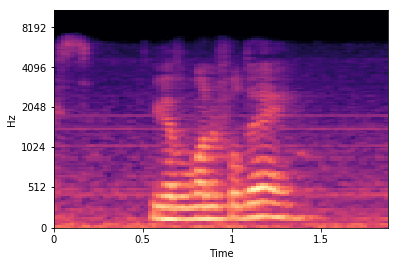

In [69]:
S = librosa.feature.melspectrogram(np.asarray(y), sr=sr, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

In [ ]:
# save_path = pathImage + "neu" + '/' + image_fname + '.jpg'

In [ ]:
from PIL import Image
im=Image.open('/home/user/shaheen.perveen/SER_new/IEMOCAP_image/neutral/Ses05F_impro05_M010.jpg')
im.size


(300, 200)

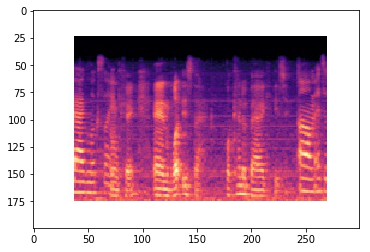

In [ ]:
plt.imshow(im)
plt.show()

In [ ]:
im_resize = im.resize((256, 256), Image.ANTIALIAS)

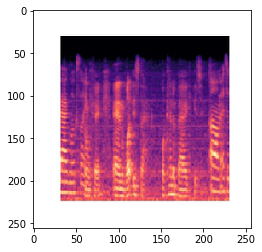

In [ ]:
plt.imshow(im_resize)
plt.show()